<a href="https://colab.research.google.com/github/zakland/zakland/blob/main/Word_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cara download data dari Kaggle: https://www.kaggle.com/general/74235

Link download data: https://www.kaggle.com/team-ai/spam-text-message-classification

# 1 Download Data

In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d team-ai/spam-text-message-classification

  0% 0.00/208k [00:00<?, ?B/s]
100% 208k/208k [00:00<00:00, 31.7MB/s]


In [ ]:
! unzip spam-text-message-classification.zip

Archive:  spam-text-message-classification.zip
  inflating: SPAM text message 20170820 - Data.csv  


# 2 Read Data

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('SPAM text message 20170820 - Data.csv')

In [ ]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df.iloc[1612]

Category    ham
Message     645
Name: 1612, dtype: object

In [ ]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


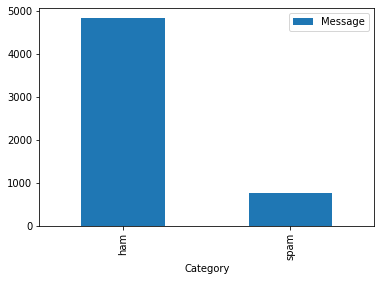

In [ ]:
df.groupby('Category').count().plot.bar()

# 3 Text Classification

In [ ]:
import nltk
nltk.download('punkt')

import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout, LSTM, Embedding, Flatten
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 3.1 Preprocessing

In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-03-20 03:24:38--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.250.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.250.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  47.8MB/s    in 34s     

2021-03-20 03:25:12 (46.8 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
!pip install gensim
from gensim.models import KeyedVectors

In [ ]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [ ]:
def tokenize(data):
    tokenized=[]
    for d in data:
        tokenized.append(nltk.word_tokenize(d.lower()))
    return tokenized

In [ ]:
def vectorize(tokenized_data):
    vectorized=[]
    for sentence in tokenized_data:
        sentvec = []
        for w in sentence:
          if w in word2vec.vocab:
            sentvec.append(word2vec[w])
          else:
            sentvec.append(np.zeros((300)))
        vectorized.append(sentvec)
    return vectorized

In [ ]:
def padding(vec):
  padded = []
  for i, v in enumerate(vec):
    vector = []
    if len(v) < max_length:
      pad_count = max_length - len(v)
      pad = np.zeros((pad_count, 300))
      vector = np.append(v, pad,axis = 0)
    else:
      vector = v[:max_length]
    padded.append(vector)
  return padded

In [ ]:
max_length = 50

In [ ]:
label = LabelEncoder().fit_transform(df['Category'])
label

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Message'], label, test_size=0.2, random_state=42)

In [ ]:
X_train_tok = tokenize(X_train)
X_test_tok = tokenize(X_test)

In [ ]:
X_train_vec = vectorize(X_train_tok)
X_test_vec = vectorize(X_test_tok)

In [ ]:
X_train_pad= padding(X_train_vec)
X_test_pad = padding(X_test_vec)

In [ ]:
X_train_pad = np.array(X_train_pad)
X_test_pad = np.array(X_test_pad)

In [ ]:
print(X_train_pad.shape)
print(X_test_pad.shape)

(4457, 50, 300)
(1115, 50, 300)


## 3.2 Model

In [ ]:
#input shape = (50,300)

In [ ]:
model = Sequential([
                    LSTM(200, input_shape=(X_train_pad.shape[1], X_train_pad.shape[2]), return_sequences=True),
                    LSTM(100, activation='sigmoid', return_sequences=True),
                    Dropout(0.5),
                    LSTM(50, activation='sigmoid'),
                    Dropout(0.5),
                    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
print ('Fitting model...')
hist = model.fit(X_train_pad, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose = 1)

Fitting model...
Epoch 1/10
63/63 [==============================] - 31s 412ms/step - loss: 0.4496 - accuracy: 0.8393 - val_loss: 0.3393 - val_accuracy: 0.8924
Epoch 2/10
63/63 [==============================] - 25s 393ms/step - loss: 0.2920 - accuracy: 0.9180 - val_loss: 0.1896 - val_accuracy: 0.9439
Epoch 3/10
63/63 [==============================] - 25s 400ms/step - loss: 0.2075 - accuracy: 0.9380 - val_loss: 0.1709 - val_accuracy: 0.9484
Epoch 4/10
63/63 [==============================] - 25s 397ms/step - loss: 0.1494 - accuracy: 0.9607 - val_loss: 0.1514 - val_accuracy: 0.9596
Epoch 5/10
63/63 [==============================] - 25s 401ms/step - loss: 0.1253 - accuracy: 0.9652 - val_loss: 0.1543 - val_accuracy: 0.9529
Epoch 6/10
63/63 [==============================] - 25s 395ms/step - loss: 0.1227 - accuracy: 0.9610 - val_loss: 0.1281 - val_accuracy: 0.9641
Epoch 7/10
63/63 [==============================] - 25s 390ms/step - loss: 0.0882 - accuracy: 0.9753 - val_loss: 0.1603 - val

In [ ]:
model.evaluate(X_test_pad, y_test)

35/35 [==============================] - 3s 83ms/step - loss: 0.0856 - accuracy: 0.9794


[0.08562514185905457, 0.9793722033500671]